In [1]:
using Pkg; Pkg.activate("..");

using Revise
using StochasticFrontiers;

  Activating project at `~/Documents/project/StochasticFrontiers.jl`
[ Info: Precompiling StochasticFrontiers [207de5b1-58d8-4e40-9f1b-ffdd2ece041b]


In [22]:
# model specification
res = sfmodel_fit(
    spec = sfspec(
        usedata("data/SNCreData.csv"),
        model      = :SNCre, 
        type       = :Prod, 
        dist       = Half(σᵤ² = :_cons), 
        σᵥ²        = :_cons, 
        ivar       = :i, 
        depvar     = :log_y, 
        frontiers  = (:log_x1, :log_x2, :t), 
        serialcorr = AR(1), 
        R          = 250, 
        σₑ²        = :_cons,
        verbose    = false
    ),
    options = sfopt(
        warmstart_solver = nothing, 
        main_solver      = :NewtonTrustRegion
    ), 
    init = sfinit([
        0.5227960098102571,        # coefficient of explanatory variables
        0.1868939866287993,        # coefficient of explanatory variables
        0.007442174221837823,      # coefficient of time effect
        -1.6397116052113527*2,     # log_σᵤ²
        -3.3244812689250423*2,     # log_σᵥ²
        0.3484365793340449,        # coefficient of fixed effect(mean of x1)
        -0.05768082007032795,      # coefficient of fixed effect2(mean of x2)
        -0.5943654485109733/14.5,  # costant term of fixed effect3(mean of x3)
        -0.8322378217931871*2,     # log_σₑ²
        0.,
    ])
);


*********************************
      Model Specification      
*********************************

    flexible panel stochastic frontier model with serially correlated errors

    Yᵢₜ = αᵢ + Xᵢₜ*β + T*π + ϵᵢₜ
        where αᵢ = δ₀ + X̄ᵢ'* δ₁ + eᵢ,

        and since the serial correlated assumptions is AR1,
            ϵᵢₜ = ρ1 * ϵᵢₜ₋1  + ηᵢₜ
            ηᵢₜ = vᵢₜ - uᵢₜ

        further,     
            vᵢₜ ∼ N(0, σᵥ²),
            σᵥ²  = exp(log_σᵥ²)

            uᵢₜ ∼ N⁺(0, σᵤ²),
            σᵤ² = exp(log_σᵤ²)

            eᵢ ∼ N(0, σₑ²)
            σᵤ² = exp(log_σₑ²)

    In the case of type(cost), "- uᵢₜ" above should be changed to "+ uᵢₜ"

*********************************
        Estimation Results 
*********************************

 Numberf Of Observations:    2296
 Log-likelihood Value:       3531.74644
 Time Consuming:             94.85233688354492

 Converged:                  true
 Number Of Total Iterations: 29
 Iteration Limit Reached:    false

┌──────────┬─────────

In [19]:
sfopt_detail(res)


 * optimization 

 * Status: success

 * Candidate solution
    Final objective value:     -3.531746e+03

 * Found with
    Algorithm:     Newton's Method (Trust Region)

 * Convergence measures
    |x - x'|               = 1.39e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.07e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.64e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.03e-15 ≰ 0.0e+00
    |g(x)|                 = 3.70e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   103  (vs limit Inf)
    Iterations:    29
    f(x) calls:    30
    ∇f(x) calls:   30
    ∇²f(x) calls:  23



In [5]:
sfmaximum(res)

3531.74644

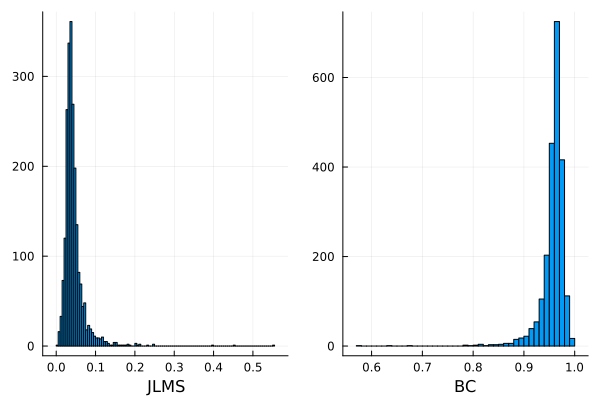

In [6]:
plot_inefficieny(res)